In [1]:
import numpy as np
import os
import pandas as pd
from itkwidgets import view
#!pip install tensorboard
from torch.utils.tensorboard import SummaryWriter
from torch.hub import load_state_dict_from_url

from torch.optim import lr_scheduler
path_to_HGG = "{}/MICCAI_BraTS_2019_Data_Training/HGG/".format(os.getcwd())
path_to_LGG = "{}/MICCAI_BraTS_2019_Data_Training/LGG/".format(os.getcwd())
root_dir = "MICCAI_BraTS_2019_Data_Training"
name_map = {"train":"Train_DS.csv","test":"Test_DS.csv"}
path_to_survival = "{}/MICCAI_BraTS_2019_Data_Training/survival_data.csv".format(os.getcwd())
types_file = ["_flair.nii.gz","_t1.nii.gz","_t1ce.nii.gz","_t2.nii.gz"]


In [2]:
"""
name_map = pd.read_csv(path_to_name_map,delimiter=',') 
survival_data = pd.read_csv(path_to_survival,delimiter=',') 
name_map = name_map.drop(['BraTS_2017_subject_ID','BraTS_2018_subject_ID','TCGA_TCIA_subject_ID'], 1)
name_map.to_csv('Name_and_tag.csv')
"""

"\nname_map = pd.read_csv(path_to_name_map,delimiter=',') \nsurvival_data = pd.read_csv(path_to_survival,delimiter=',') \nname_map = name_map.drop(['BraTS_2017_subject_ID','BraTS_2018_subject_ID','TCGA_TCIA_subject_ID'], 1)\nname_map.to_csv('Name_and_tag.csv')\n"

In [3]:
#!pip install torch torchvision torchaudio
#!pip install torchio
import torch
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
import matplotlib as plt
import seaborn as sns
from skimage import io

from itkwidgets import view
device = torch.device("cuda:0")
import torchio as tio

In [4]:
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix,jaccard_score, accuracy_score,f1_score,average_precision_score
from PIL import Image
from skimage import io, transform
import torch.utils.data as data_utils
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torchvision import datasets, transforms,models
import torchvision
from sklearn.model_selection import train_test_split

In [5]:

temp = pd.read_csv("Name_and_tag.csv",delimiter=',')
len_hgg = len(temp[temp["Grade"]=="HGG"])
len_lgg = len(temp[temp["Grade"]=="LGG"])



split_size = 0.80
ovsempl = 1.10

tmp_hgg = temp[int(len_hgg*split_size):len_hgg]
tmp_lgg = temp[len_hgg + int(len_lgg*split_size):(len_hgg+len_lgg)]
tmp_lgg = tmp_lgg.drop('Unnamed: 0', 1)
tmp_hgg = tmp_hgg.drop('Unnamed: 0', 1)
tmp_hgg = tmp_hgg.to_dict()
tmp_lgg = tmp_lgg.to_dict()
tmp_hgg['Grade'].update(tmp_lgg['Grade'])
tmp_hgg['BraTS_2019_subject_ID'].update(tmp_lgg['BraTS_2019_subject_ID'])
test_data = pd.DataFrame.from_dict(tmp_hgg)
print(len(test_data))
test_data.to_csv('Test_DS.csv')


 
tmp_hgg = temp[:int(len_lgg*ovsempl*split_size)] #tmp_hgg = temp[:int(len_hgg*split_size)]
tmp_lgg = temp[len_hgg:len_hgg+int(len_lgg*split_size)]
tmp_lgg = tmp_lgg.drop('Unnamed: 0', 1)
tmp_hgg = tmp_hgg.drop('Unnamed: 0', 1)
tmp_hgg = tmp_hgg.to_dict()
tmp_lgg = tmp_lgg.to_dict()
tmp_hgg['Grade'].update(tmp_lgg['Grade'])
tmp_hgg['BraTS_2019_subject_ID'].update(tmp_lgg['BraTS_2019_subject_ID'])
test_data = pd.DataFrame.from_dict(tmp_hgg)
print(len(test_data))
test_data.to_csv('Train_DS.csv')

68
126


In [6]:
test_data

,Grade,BraTS_2019_subject_ID
0,HGG,BraTS19_CBICA_AAB_1
1,HGG,BraTS19_CBICA_AAG_1
2,HGG,BraTS19_CBICA_AAL_1
3,HGG,BraTS19_CBICA_AAP_1
4,HGG,BraTS19_CBICA_ABB_1
...,...,...
314,LGG,BraTS19_TCIA10_632_1
315,LGG,BraTS19_TCIA10_637_1
316,LGG,BraTS19_TCIA12_470_1
317,LGG,BraTS19_TCIA12_480_1


In [7]:
def plot_class_histogram(markup_map, title=None):
    ax = sns.catplot(x='Grade', data=markup_map, kind="count", palette="ch:.25")
    ax.fig.suptitle(title or 'Распределение классов повреждений')
    ax.fig.set_size_inches(10,5)
    #plt.ylim(0, markup_map.ClassId.value_counts().max() + 100)
    #plt.show()

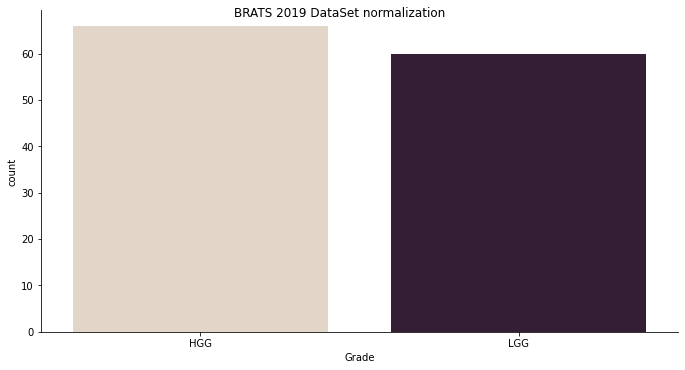

In [8]:
plot_class_histogram(test_data, title='BRATS 2019 DataSet normalization')

In [9]:
class BratsDataset(Dataset):
    
    def __init__(self, csv_file , root_dir,types_file, transform=None):
        self.labels_frame = pd.read_csv(csv_file,delimiter=',')
        self.root_dir = root_dir
        self.transform = transform
        self.types_file = types_file
        
    def __len__(self):
        return len(self.labels_frame)
        
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()
        img_name = os.path.join(self.root_dir, self.labels_frame.iloc[idx,1],self.labels_frame.iloc[idx,2],
                                "{}{}".format(self.labels_frame.iloc[idx,2],self.types_file))
        img = nib.load(img_name)
        img = np.array(img.dataobj)
        img = torch.from_numpy(img)
        img = img.unsqueeze(0)
        img = img.repeat(3,1,1,1)
        img = img.type(torch.FloatTensor)
        
        label = self.labels_frame.iloc[idx, 1]
           
        label = 0 if label == "HGG" else 1
        label = np.array([label])
        label = torch.from_numpy(label)
        label = label.type(torch.LongTensor)
        if self.transform:
            img = self.transform(img)
            
        return img, label

In [10]:
print(len(test_data[test_data["Grade"] == "HGG"]), len(test_data[test_data["Grade"] == "LGG"]))

66 60


In [11]:
brain_train[0][0].shape

NameError: name 'brain_train' is not defined

In [12]:
#https://torchio.readthedocs.io/data/subject.html
transform=transforms.Compose(
        [
            
            lambda x: (x-x.min())/(x.max()-x.min()), #2*((x-x.min())/(x.max()-x.min())) - 1,
            #lambda x: x[np.newaxis, :, :, :],
            lambda x: x.clone().detach(),
            #lambda x: torch.tensor(x, dtype=torch.float32),
#           
        ]
    )

In [13]:
brain_train = BratsDataset(csv_file = name_map["train"],root_dir = root_dir,types_file = types_file[1],transform=transform)
brain_test = BratsDataset(csv_file = name_map["test"],root_dir = root_dir,types_file = types_file[1],transform=transform)


In [14]:
len(brain_train)

126

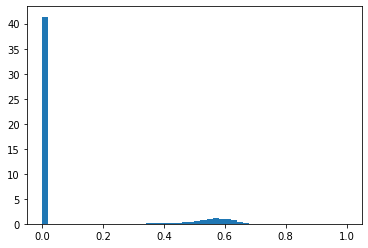

In [15]:
plt.hist(np.array(brain_train[90][0]).ravel(), bins=50, density=True);

In [16]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    view(image[0,:,:,:])
    #plt.figure(figsize=(30, 3))
    #plt.subplot(1, 1,1)
    #plt.grid(False)
    #plt.imshow(image[0,:,:,95])
    #plt.axis('off')
    #print(landmarks)


In [17]:
show_landmarks(brain_test[10][0],brain_test[2][1])
view(brain_test[10][0][0,:,:,:])

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

In [16]:
def sempler(data_train, batch_size = 4,split = .8):
    
    data_size = len(data_train)

    validation_split = split
    split = int(np.floor(validation_split * data_size))
    indices = list(range(data_size))
    np.random.shuffle(indices)

    train_indices,val_indices = indices[split:],indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                                   sampler=train_sampler,)
    
    val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                                 sampler=val_sampler,)

    return train_loader,val_loader

In [17]:
len(brain_test)

68

In [18]:
train_loader, val_loader = sempler(brain_train, split=0.2)
test_loader = torch.utils.data.DataLoader(brain_test, batch_size=4,
                                                   shuffle=True)
print(len(test_loader))

17


In [19]:
import gc

def train_model(model,train_loader,val_loader,loss,optimizer, num_epochs,writer):
    loss_history = []
    train_history = []
    val_history = []
    val_loss_hist = []
    metric_y_val = metric_p_val = None
    
    scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                  T_0=40, 
                                                  T_mult=2,
                                                  eta_min=1e-9)
    for epoch in range(num_epochs):
        
        print(epoch)
        model.train()
        
        correct_samples = 0
        total_samples = 0
        loss_accum = 0
        for i_step, (x, y) in enumerate(train_loader):
                
                x_gpu = x.to(device=device)
                y_gpu = y.to(device=device)
                
                prediction = model(x_gpu)
                loss_value = loss(prediction, y_gpu.reshape((-1,)))
                _, preds = torch.max(prediction, 1)
                

                optimizer.zero_grad()
                loss_value.backward()
                optimizer.step()
                
                
                if i_step == 0 and epoch == 0:
                    metric_y = y_gpu.reshape((-1,)).cpu().numpy()
                    metric_p = preds.cpu().numpy()
                else:
                    metric_y = np.concatenate((metric_y, y_gpu.reshape((-1,)).cpu().numpy()))
                    metric_p = np.concatenate((metric_p, preds.cpu().numpy())) 
                    
                correct_samples += torch.sum(preds == y_gpu.reshape((-1,)))
                loss_accum += loss_value
                
                total_samples += y_gpu.shape[0]
                del x_gpu
                del y_gpu
                #gc.collect()
        
        
        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = correct_samples / total_samples
        writer.add_scalar("Loss/train", ave_loss, epoch)
        writer.add_scalar("Acc/train", train_accuracy, epoch)
        writer.add_scalar("F1/train", f1_score(metric_y,metric_p), epoch)

        val_accuracy, loss_val,metric_y_val, metric_p_val = compute_valid(model, val_loader, loss, epoch,metric_y_val, metric_p_val)
        writer.add_scalar("Loss/valid", loss_val, epoch)
        writer.add_scalar("Acc/valid", val_accuracy, epoch)
        writer.add_scalar("F1/valid", f1_score(metric_y_val,metric_p_val), epoch)
        
        writer.add_scalar("Lr/epoch", scheduler.get_last_lr()[-1], epoch)
        scheduler.step(epoch)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        val_loss_hist.append(loss_val)

        print("Average loss: %f, Val loss: %f, Train accuracy: %f, Val accuracy: %f, Train AP: %f,Val AP: %f" % (ave_loss,loss_val, train_accuracy, val_accuracy,average_precision_score(metric_y,metric_p),average_precision_score(metric_y_val,metric_p_val)))
        
        print('Epoch:', epoch, 'LR:', scheduler.get_last_lr())
        
        #if epoch > 1 and loss_step(loss_history, epoch,):
            #scheduler.step()
            
        #if epoch > 1 and loss_step(val_loss_hist, epoch,):
            #scheduler.step()
    
    return model, loss_history, train_history, val_history, val_loss_hist,metric_y,metric_p, metric_y_val, metric_p_val

def loss_step(loss_history, epoch):
    if loss_history[epoch - 1] >= loss_history[epoch - 2] or loss_history[epoch - 1] * 1.02 >= loss_history[epoch - 2]:
        return True
    else:
        return False 


def compute_valid(model, loader, loss,epoch, metric_y= None, metric_p=None):
    model.eval()
    with torch.no_grad():
        correct_samples = 0
        total_samples = 0
        loss_accum = 0
        
        for i_step, (x, y) in enumerate(loader):
            x_gpu = x.to(device=device, dtype=torch.float)
            y_gpu = y.to(device=device,)

            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu.reshape((-1,)))
            _, preds = torch.max(prediction, 1)
            
            
            if i_step == 0 and epoch == 0:
                metric_y = y_gpu.reshape((-1,)).cpu().numpy()
                metric_p = preds.cpu().numpy()
            else:
                metric_y = np.concatenate((metric_y, y_gpu.reshape((-1,)).cpu().numpy()))
                metric_p = np.concatenate((metric_p, preds.cpu().numpy())) 
            
            
            correct_samples += torch.sum(preds == y_gpu.reshape((-1,)))
            total_samples += y_gpu.shape[0]
            loss_accum += loss_value

            del x_gpu
            del y_gpu
                
        loss_val = loss_accum / (i_step + 1)
        val_accuracy = correct_samples / total_samples
        return val_accuracy, loss_val, metric_y, metric_p
    

In [23]:
import torch
import torch.nn as nn

"""
Changed 2d to 3d
https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
"""


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv3d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv3d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm3d
            #pass
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU6(inplace=True)
        #self.dp1 = nn.Dropout(0.2)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        #out = self.dp1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm3d
            #pass
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU6(inplace=True)
        #self.dp1 = nn.Dropout(0.2)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        out = self.dp1(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm3d
            #pass
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv3d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU6(inplace=True)
        #self.dp1 = nn.Dropout(0.15)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        #self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       #dilate=replace_stride_with_dilation[1])
        #self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       #dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(128 * block.expansion, num_classes)
        self.softmax = nn.Softmax()

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm3d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
#                 norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation,  norm_layer))
                            # self.base_width, previous_dilation))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))
                                # ))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        #x = self.bn1(x)
        x = self.relu(x)
        #x = self.dp1(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        # x = self.layer3(x)
        # x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.fc(x)
        x = self.softmax(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        model_dict = model.state_dict()
        pretrained_dict = load_state_dict_from_url("https://download.pytorch.org/models/resnet18-f37072fd.pth")
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict) 
        dell = []
        for key in pretrained_dict.keys():
            size = pretrained_dict.get(key).size()
            if len(size) > 2:
                k = pretrained_dict.get(key)
                temp = k[0][0][0]
                k = k.unsqueeze(4)
                k = k.repeat(1,1,1,1,size[-1])
                k[0][0][0][0] = temp
                pretrained_dict[key] = k
            if (key.find("fc") != -1 and len(size) > 1):
                k = pretrained_dict.get(key)
                k = k.reshape([1000,128,4])
                k = k.mean(2)
                pretrained_dict[key] = k       
        model.load_state_dict(pretrained_dict)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [1, 1, 1, 1], pretrained, progress,
                   **kwargs)


def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained=False, progress=True, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained=False, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)



In [23]:
import torch
import torch.nn as nn

"""
Changed 2d to 3d
https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
"""


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv3d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv3d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
#             norm_layer = nn.BatchNorm3d
            pass
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
#         self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
#         self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
#         out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
#         out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
#             norm_layer = nn.BatchNorm3d
            pass
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
#         self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
#         self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
#         self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
#         out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
#         out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
#         out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
#             norm_layer = nn.BatchNorm3d
            pass
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv3d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
#         self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        #self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       #dilate=replace_stride_with_dilation[1])
        #self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       #dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(128 * block.expansion, num_classes)
        #self.softmax = nn.Softmax()

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm3d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
#                 norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation,  norm_layer))
                            # self.base_width, previous_dilation))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))
                                # ))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
#         x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        # x = self.layer3(x)
        # x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.fc(x)
        x = self.softmax(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained=False, progress=True, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained=False, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)



In [24]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)



In [26]:
#torch.save(model, "model_true_bath_t2_.pth")
model = resnet18(pretrained=True)
model.fc = nn.Sequential(
                         nn.Linear(128, 2),
                        )
model

ResNet(
  (conv1): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU6(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU6(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine

In [25]:
model = resnet18(pretrained=True) 

model.fc = nn.Sequential(
                         nn.Linear(128, 2),
                        )
"""

"""
model.softmax.dim = 1
model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-04, weight_decay = 1e-06)

writer = SummaryWriter()
model , loss_history, train_history, val_history, val_loss_hist,metric_y_train,metric_p_train,metric_y_val, metric_p_val = train_model(model,train_loader, val_loader, loss, optimizer, 175,writer)
writer.flush()
writer.close()


torch.save(model.state_dict(), "t1_pretr_dp_f_v3_.pth")

print("Train")
print("Accuracy {}".format(accuracy_score(metric_y_train, metric_p_train)))
target_names = ['HGG', 'LGG']
print(classification_report(metric_y_train,metric_p_train,target_names=target_names))
print(confusion_matrix(metric_y_train,metric_p_train))
print("Jaccard score {}".format(jaccard_score(metric_y_train,metric_p_train)))




print("Valid")
print("Accuracy {}".format(accuracy_score(metric_y_val, metric_p_val)))
target_names = ['HGG', 'LGG']
print(classification_report(metric_y_val, metric_p_val,target_names=target_names))
print(confusion_matrix(metric_y_val,metric_p_val))
print("Jaccard score {}".format(jaccard_score(metric_y_val,metric_p_val)))





metric_y , metric_p = pred_test(test_loader,model)

print("Test")
print("Accuracy {}".format(accuracy_score(metric_y, metric_p)))
target_names = ['HGG', 'LGG']
print(classification_report(metric_y, metric_p,target_names=target_names))
print(confusion_matrix(metric_y,metric_p))
print("Jaccard score {}".format(jaccard_score(metric_y,metric_p)))


0
Average loss: 0.691130, Val loss: 0.651223, Train accuracy: 0.504950, Val accuracy: 0.600000, Train AP: 0.495050,Val AP: 0.400000
Epoch: 0 LR: [0.0001]
1
Average loss: 0.677073, Val loss: 0.653132, Train accuracy: 0.544554, Val accuracy: 0.760000, Train AP: 0.511964,Val AP: 0.520000
Epoch: 1 LR: [9.984586822798955e-05]
2
Average loss: 0.664418, Val loss: 0.619474, Train accuracy: 0.702970, Val accuracy: 0.800000, Train AP: 0.562706,Val AP: 0.563590
Epoch: 2 LR: [9.93844231855866e-05]
3
Average loss: 0.649794, Val loss: 0.617183, Train accuracy: 0.722772, Val accuracy: 0.880000, Train AP: 0.589778,Val AP: 0.616667
Epoch: 3 LR: [9.861850983492364e-05]
4
Average loss: 0.634532, Val loss: 0.581926, Train accuracy: 0.752475, Val accuracy: 0.800000, Train AP: 0.613266,Val AP: 0.625818
Epoch: 4 LR: [9.755285028649954e-05]
5
Average loss: 0.631373, Val loss: 0.598711, Train accuracy: 0.762376, Val accuracy: 0.880000, Train AP: 0.630536,Val AP: 0.650909
Epoch: 5 LR: [9.619401468579809e-05]
6


Average loss: 0.497799, Val loss: 0.419898, Train accuracy: 0.881188, Val accuracy: 1.000000, Train AP: 0.825977,Val AP: 0.770858
Epoch: 49 LR: [9.690959770045626e-05]
50
Average loss: 0.478134, Val loss: 0.404977, Train accuracy: 0.871287, Val accuracy: 1.000000, Train AP: 0.826050,Val AP: 0.774664
Epoch: 50 LR: [9.619401468579809e-05]
51
Average loss: 0.504705, Val loss: 0.423015, Train accuracy: 0.871287, Val accuracy: 0.960000, Train AP: 0.825998,Val AP: 0.777258
Epoch: 51 LR: [9.540720461966716e-05]
52
Average loss: 0.439363, Val loss: 0.423688, Train accuracy: 0.960396, Val accuracy: 1.000000, Train AP: 0.828239,Val AP: 0.780842
Epoch: 52 LR: [9.45503807061563e-05]
53
Average loss: 0.457105, Val loss: 0.611135, Train accuracy: 0.891089, Val accuracy: 0.760000, Train AP: 0.828873,Val AP: 0.776853
Epoch: 53 LR: [9.362486410563633e-05]
54
Average loss: 0.464656, Val loss: 0.685085, Train accuracy: 0.900990, Val accuracy: 0.440000, Train AP: 0.829548,Val AP: 0.763636
Epoch: 54 LR: [9

Average loss: 0.394286, Val loss: 0.385361, Train accuracy: 0.970297, Val accuracy: 0.920000, Train AP: 0.864817,Val AP: 0.777732
Epoch: 97 LR: [1.9046112081482967e-05]
98
Average loss: 0.384698, Val loss: 0.410313, Train accuracy: 0.960396, Val accuracy: 0.920000, Train AP: 0.865505,Val AP: 0.778505
Epoch: 98 LR: [1.7528422307514986e-05]
99
Average loss: 0.385435, Val loss: 0.370467, Train accuracy: 0.980198, Val accuracy: 0.960000, Train AP: 0.866521,Val AP: 0.779726
Epoch: 99 LR: [1.606080212372569e-05]
100
Average loss: 0.376041, Val loss: 0.383215, Train accuracy: 0.980198, Val accuracy: 0.960000, Train AP: 0.867446,Val AP: 0.780925
Epoch: 100 LR: [1.4645514494063221e-05]
101
Average loss: 0.381619, Val loss: 0.370370, Train accuracy: 0.980198, Val accuracy: 0.960000, Train AP: 0.868423,Val AP: 0.782102
Epoch: 101 LR: [1.3284741689470435e-05]
102
Average loss: 0.381370, Val loss: 0.368319, Train accuracy: 0.990099, Val accuracy: 1.000000, Train AP: 0.869479,Val AP: 0.783918
Epoch:

Average loss: 0.416480, Val loss: 0.422309, Train accuracy: 0.910891, Val accuracy: 0.920000, Train AP: 0.887208,Val AP: 0.786510
Epoch: 145 LR: [9.409612225678558e-05]
146
Average loss: 0.376851, Val loss: 0.416200, Train accuracy: 0.960396, Val accuracy: 0.920000, Train AP: 0.887572,Val AP: 0.786828
Epoch: 146 LR: [9.362486410563633e-05]
147
Average loss: 0.402863, Val loss: 0.359893, Train accuracy: 0.920792, Val accuracy: 1.000000, Train AP: 0.887560,Val AP: 0.788064
Epoch: 147 LR: [9.313678793169661e-05]
148
Average loss: 0.388482, Val loss: 0.396559, Train accuracy: 0.950495, Val accuracy: 0.960000, Train AP: 0.887899,Val AP: 0.788826
Epoch: 148 LR: [9.263208189762244e-05]
149
Average loss: 0.382138, Val loss: 0.386913, Train accuracy: 0.950495, Val accuracy: 0.960000, Train AP: 0.888135,Val AP: 0.789578
Epoch: 149 LR: [9.211094057719748e-05]
150
Average loss: 0.377314, Val loss: 0.369620, Train accuracy: 0.980198, Val accuracy: 1.000000, Train AP: 0.888714,Val AP: 0.790776
Epoch

NameError: name 'pred_test' is not defined

In [27]:
!tensorboard --logdir runs --port=8880

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.5.0 at http://localhost:8880/ (Press CTRL+C to quit)
^C


In [25]:
model = resnet18(pretrained=True)
model.fc = nn.Sequential(
                         nn.Linear(128, 2),

                        )
model.load_state_dict(torch.load("t1_pretr_dp_f_v2_.pth"))
model = model.to(device)

In [27]:
import gc

def pred_test(test_loader,model):
    model.eval()
    with torch.no_grad():
        print('Start predicting....')
        for i_step, (x, y) in enumerate(test_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)
            _, preds = torch.max(prediction, 1)
            
            if i_step == 0:
                metric_y = y_gpu.reshape((-1,)).cpu().numpy()
                metric_p = preds.cpu().numpy()
            else:
                metric_y = np.concatenate((metric_y, y_gpu.reshape((-1,)).cpu().numpy()))
                metric_p = np.concatenate((metric_p, preds.cpu().numpy())) 
                        
            del x_gpu
            del y_gpu
            
    print('Finish prediction.')
    return metric_y , metric_p

In [37]:
metric_y_val , metric_p_val = pred_test(test_loader,model)

print("Test")
print("Accuracy {}".format(accuracy_score(metric_y_val, metric_p_val)))
target_names = ['HGG', 'LGG']
print(classification_report(metric_y_val, metric_p_val,target_names=target_names))
print(confusion_matrix(metric_y_val,metric_p_val))
print("Jaccard score {}".format(jaccard_score(metric_y_val,metric_p_val)))

Start predicting....
Finish prediction.
Test
Accuracy 0.22058823529411764
              precision    recall  f1-score   support

         HGG       0.00      0.00      0.00        52
         LGG       0.22      0.94      0.36        16

    accuracy                           0.22        68
   macro avg       0.11      0.47      0.18        68
weighted avg       0.05      0.22      0.09        68

[[ 0 52]
 [ 1 15]]
Jaccard score 0.22058823529411764


In [ ]:
torch.save(model, "model_true_DP_t_.pth")